# Autonomization

Given a diagram in a free rigid category where the dom and cod of every box consists of only basic types (i.e. doesn't contain adjoint types), it is equivalent to a diagram where all cups and caps have been removed (i.e. a diagram in the underlying free monoidal category). See Theorem 2 arxiv:1411.3827

In this notebook we illustrate the above result by showing that the diagrams for parsed sentences from a simple language can be rewritten to remove all occurences of cups and caps.

In [1]:
from discopy import Ty, Box, Diagram, Word, pregroup

# Pregroup types for words use adjoints

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, who, is_rich, loves, Bob]

# word_boxes that don't use adjoints are in the underlying free monoidal category.

love_box = Box('loves', n @ n, s)
is_rich_box = Box('is rich', n, s)
split = Box('split', n, n @ n)
update = Box('update', n @ s, n)

In [2]:
from discopy import Cup, Cap, RigidFunctor

# Use a RigidFunctor to decompose the Words into  .

ob = {n: n, s: s}
ar = {Alice: Alice,
      Bob: Bob,
      loves: Cap(n.r, n) @ Cap(n, n.l) >> Diagram.id(n.r) @ love_box @ Diagram.id(n.l),
      is_rich: Cap(n.r, n) >> Diagram.id(n.r) @ is_rich_box,
      who: Cap(n.r, n) >> Diagram.id(n.r) @ (split >> Diagram.id(n) @ Cap(s, s.l) @ Diagram.id(n) >>
                                             update @ Diagram.id(s.l @ n))
     }

A = RigidFunctor(ob, ar, ob_cls=Ty, ar_cls=Diagram)

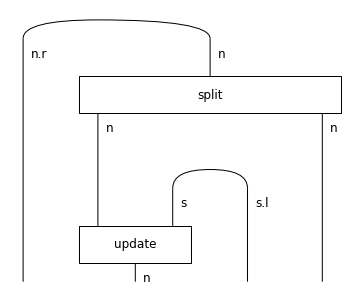

In [3]:
A(who).draw()

In [4]:
from time import time
from discopy.pregroup import brute_force

gen, n_sentences = brute_force(*vocab), 20
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("{:.2f} seconds to generate {} sentences.\n".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who is rich loves Alice.
Alice who is rich loves Bob.
Alice who loves Alice is rich.
Alice who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Alice who who is rich is rich is rich.
Alice who is rich who is rich is rich.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
10.85 seconds to generate 20 sentences.



Bob who is rich loves Alice.


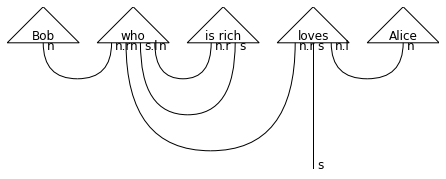

In [5]:
print(sentences[12])
pregroup.draw(parsing[sentences[12]])

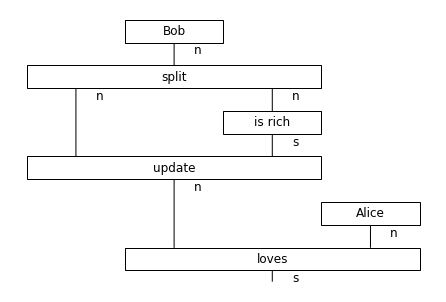

In [6]:
A(parsing[sentences[12]]).normal_form().draw(aspect='auto')

In [7]:
def has_cups(diagram):
    for box in diagram.boxes:
        if isinstance(box, Cup) or isinstance(box, Cap):
            return True
    return False

In [8]:
autonomised_sentences = [A(parsing[sentences[i]]).normal_form() for i in range(n_sentences)]

In [9]:
for i in range(n_sentences):
    assert not has_cups(autonomised_sentences[i])

# Simplifying circuit models

Using the autonomization functor defined above, we show how to reduce the 

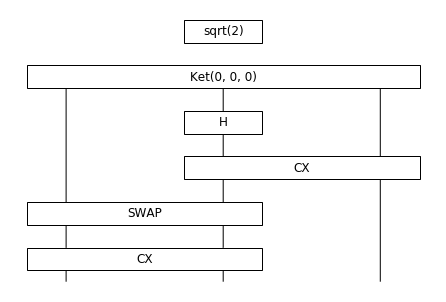

In [20]:
from discopy.circuit import Circuit, PRO, Id, CX, H, Rx, Ket, sqrt, SWAP, CircuitFunctor
import jax.numpy as np

def who_ansatz():
    return sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

def split_ansatz():
    return Circuit.id(1) @ Ket(0) >> CX

def update_ansatz():
    return Circuit.id(1)

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0) @ Ket(0) >> H @ Rx(phase) >> CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    who: who_ansatz(),
    Bob: Ket(1),
    is_rich: intransitive_ansatz(params['is_rich']),
    split: split_ansatz(),
    update: update_ansatz(),
    love_box: transitive_ansatz(- params['loves']).dagger(),
    is_rich_box: intransitive_ansatz(- params['is_rich']).dagger()}

F = lambda params: CircuitFunctor(ob, ar({'loves': params[0], 'is_rich': params[1]}))

params0 = np.array([0.5, 1.])

F(params0)(who).draw(draw_types=False, aspect='auto')

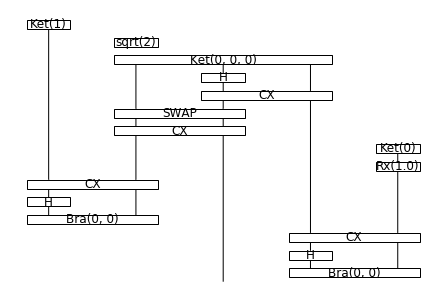

depth of the circuit: 6


In [21]:
from discopy.pregroup import eager_parse

noun_phrase = eager_parse(Bob, who, is_rich, target=n)

F(params0)(noun_phrase).draw(draw_types=False, aspect='auto')

# print depth of circuit, excluding preparation and measurement layers. 
print('depth of the circuit: {}'.format(F(params0)(noun_phrase).depth() - 2))

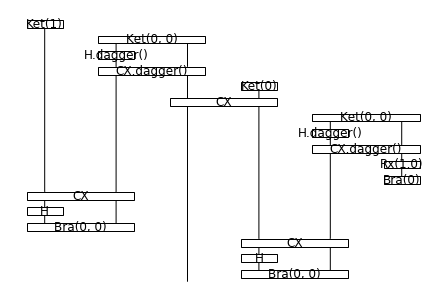

depth of the circuit: 5


In [22]:
F(params0)(A(noun_phrase)).draw(draw_types=False, aspect='auto')
print('depth of the circuit: {}'.format(F(params0)(A(noun_phrase)).depth() - 2))

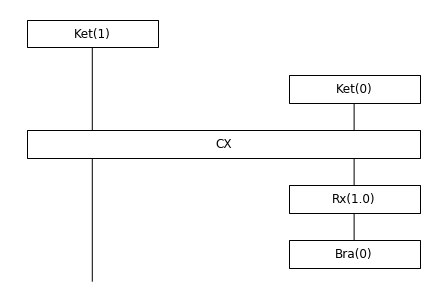

depth of the circuit: 2


In [23]:
F(params0)(A(noun_phrase).normal_form()).draw(draw_types=False, aspect='auto')
print('depth of the circuit: {}'.format(F(params0)(A(noun_phrase).normal_form()).depth() - 2))

In [28]:
print(F(params0)(A(noun_phrase)).measure())
print(F(params0)(noun_phrase).measure())
print(F(params0)(A(noun_phrase).normal_form()).measure())

[0.000000e+00 7.642742e-15]
[0.000000e+00 7.642741e-15]
[0.000000e+00 7.642742e-15]
